# Confesor_MLPClassifier (2023)
# Part of OEAS 895 Capstone Project
## This Jupyter Notebook takes indexed,cleaned, and combined WFS data from FWRI & CMEMs (Kb_final.csv) and creates a Multilayer perceptron (MLP) Model predicting K.brevis bloom occurrences on WFS 2019 data (Confesor, 2020)

### Import Packages - Using Python Version 3.11.2 (make sure ConfesorCapstoneEv is set as current kernel!)

In [1]:
#Python script with all of the necessary functions
import Confesor_Functions as CF

#For data editing
import pandas as pd
import numpy as np
import os
import string

#Graphing
import cartopy as cp
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io import shapereader
from matplotlib import rcParams, rc
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib as mpl
import string

# Model packages
from numpy.random import seed
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, make_scorer
from sklearn import metrics
from scipy import interpolate

#Make Train test parameters out of split data
from sklearn.model_selection import train_test_split, KFold, cross_val_score


#If the current working directory is not where you have saved all the necessary files, change the directory.
os.chdir('C:\\Users\\krist\\OneDrive\\Desktop\\Files\\ODU\\Spring2023\\OEAS895\\MLP_Classifier_KbrevisHABs')
os.getcwd()

'C:\\Users\\krist\\OneDrive\\Desktop\\Files\\ODU\\Spring2023\\OEAS895\\MLP_Classifier_KbrevisHABs'

### Download Data

In [2]:
#Download CMEMS & FWRI combined .csv file
Kb_final=CF.DownloadCSV('Kb_final.csv','Kb_final')
Kb_final[['Date']] = Kb_final[['Date']].apply(pd.to_datetime)
Kb_final=Kb_final.drop(columns= ['Unnamed: 0'])
Kb_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10064 entries, 0 to 10063
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       10064 non-null  datetime64[ns]
 1   Depth_m    10064 non-null  float64       
 2   Latitude   10064 non-null  float64       
 3   Longitude  10064 non-null  float64       
 4   Kbrevis    10064 non-null  int64         
 5   Temp_C     10064 non-null  float64       
 6   Salinity   10064 non-null  float64       
 7   BloomID    10064 non-null  int64         
 8   NO3        10064 non-null  float64       
 9   PO4        10064 non-null  float64       
 10  Si         10064 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(2)
memory usage: 865.0 KB


### MLP Classifier (split into train & test sets,figure out best layer/node combo)

In [3]:
# Feature matrix in a object named X- ONLY INCLUDE PARAMETERS WE NEED
x=Kb_final.drop(columns= ['BloomID','Date','Latitude','Longitude','Depth_m','Kbrevis'])
# response vector in a object named y
y = Kb_final.BloomID

label = eval('["No Bloom", "Bloom"]')
print (label)
x

['No Bloom', 'Bloom']


,Temp_C,Salinity,NO3,PO4,Si
0,17.300000,34.240000,1.959385,0.002489,11.138027
1,17.200000,30.500000,1.959385,0.002489,11.138027
2,17.600000,32.720000,1.959385,0.002489,11.138027
3,17.400000,34.770000,1.959385,0.002489,11.138027
4,17.100000,34.680000,1.959385,0.002489,11.138027
...,...,...,...,...,...
10059,20.500000,1.550000,0.020753,0.004036,3.892709
10060,21.280000,36.400000,0.982610,0.002495,14.416743
10061,21.830000,35.720000,0.866491,0.002416,14.053338
10062,13.708517,34.681232,2.500659,0.003386,14.317658


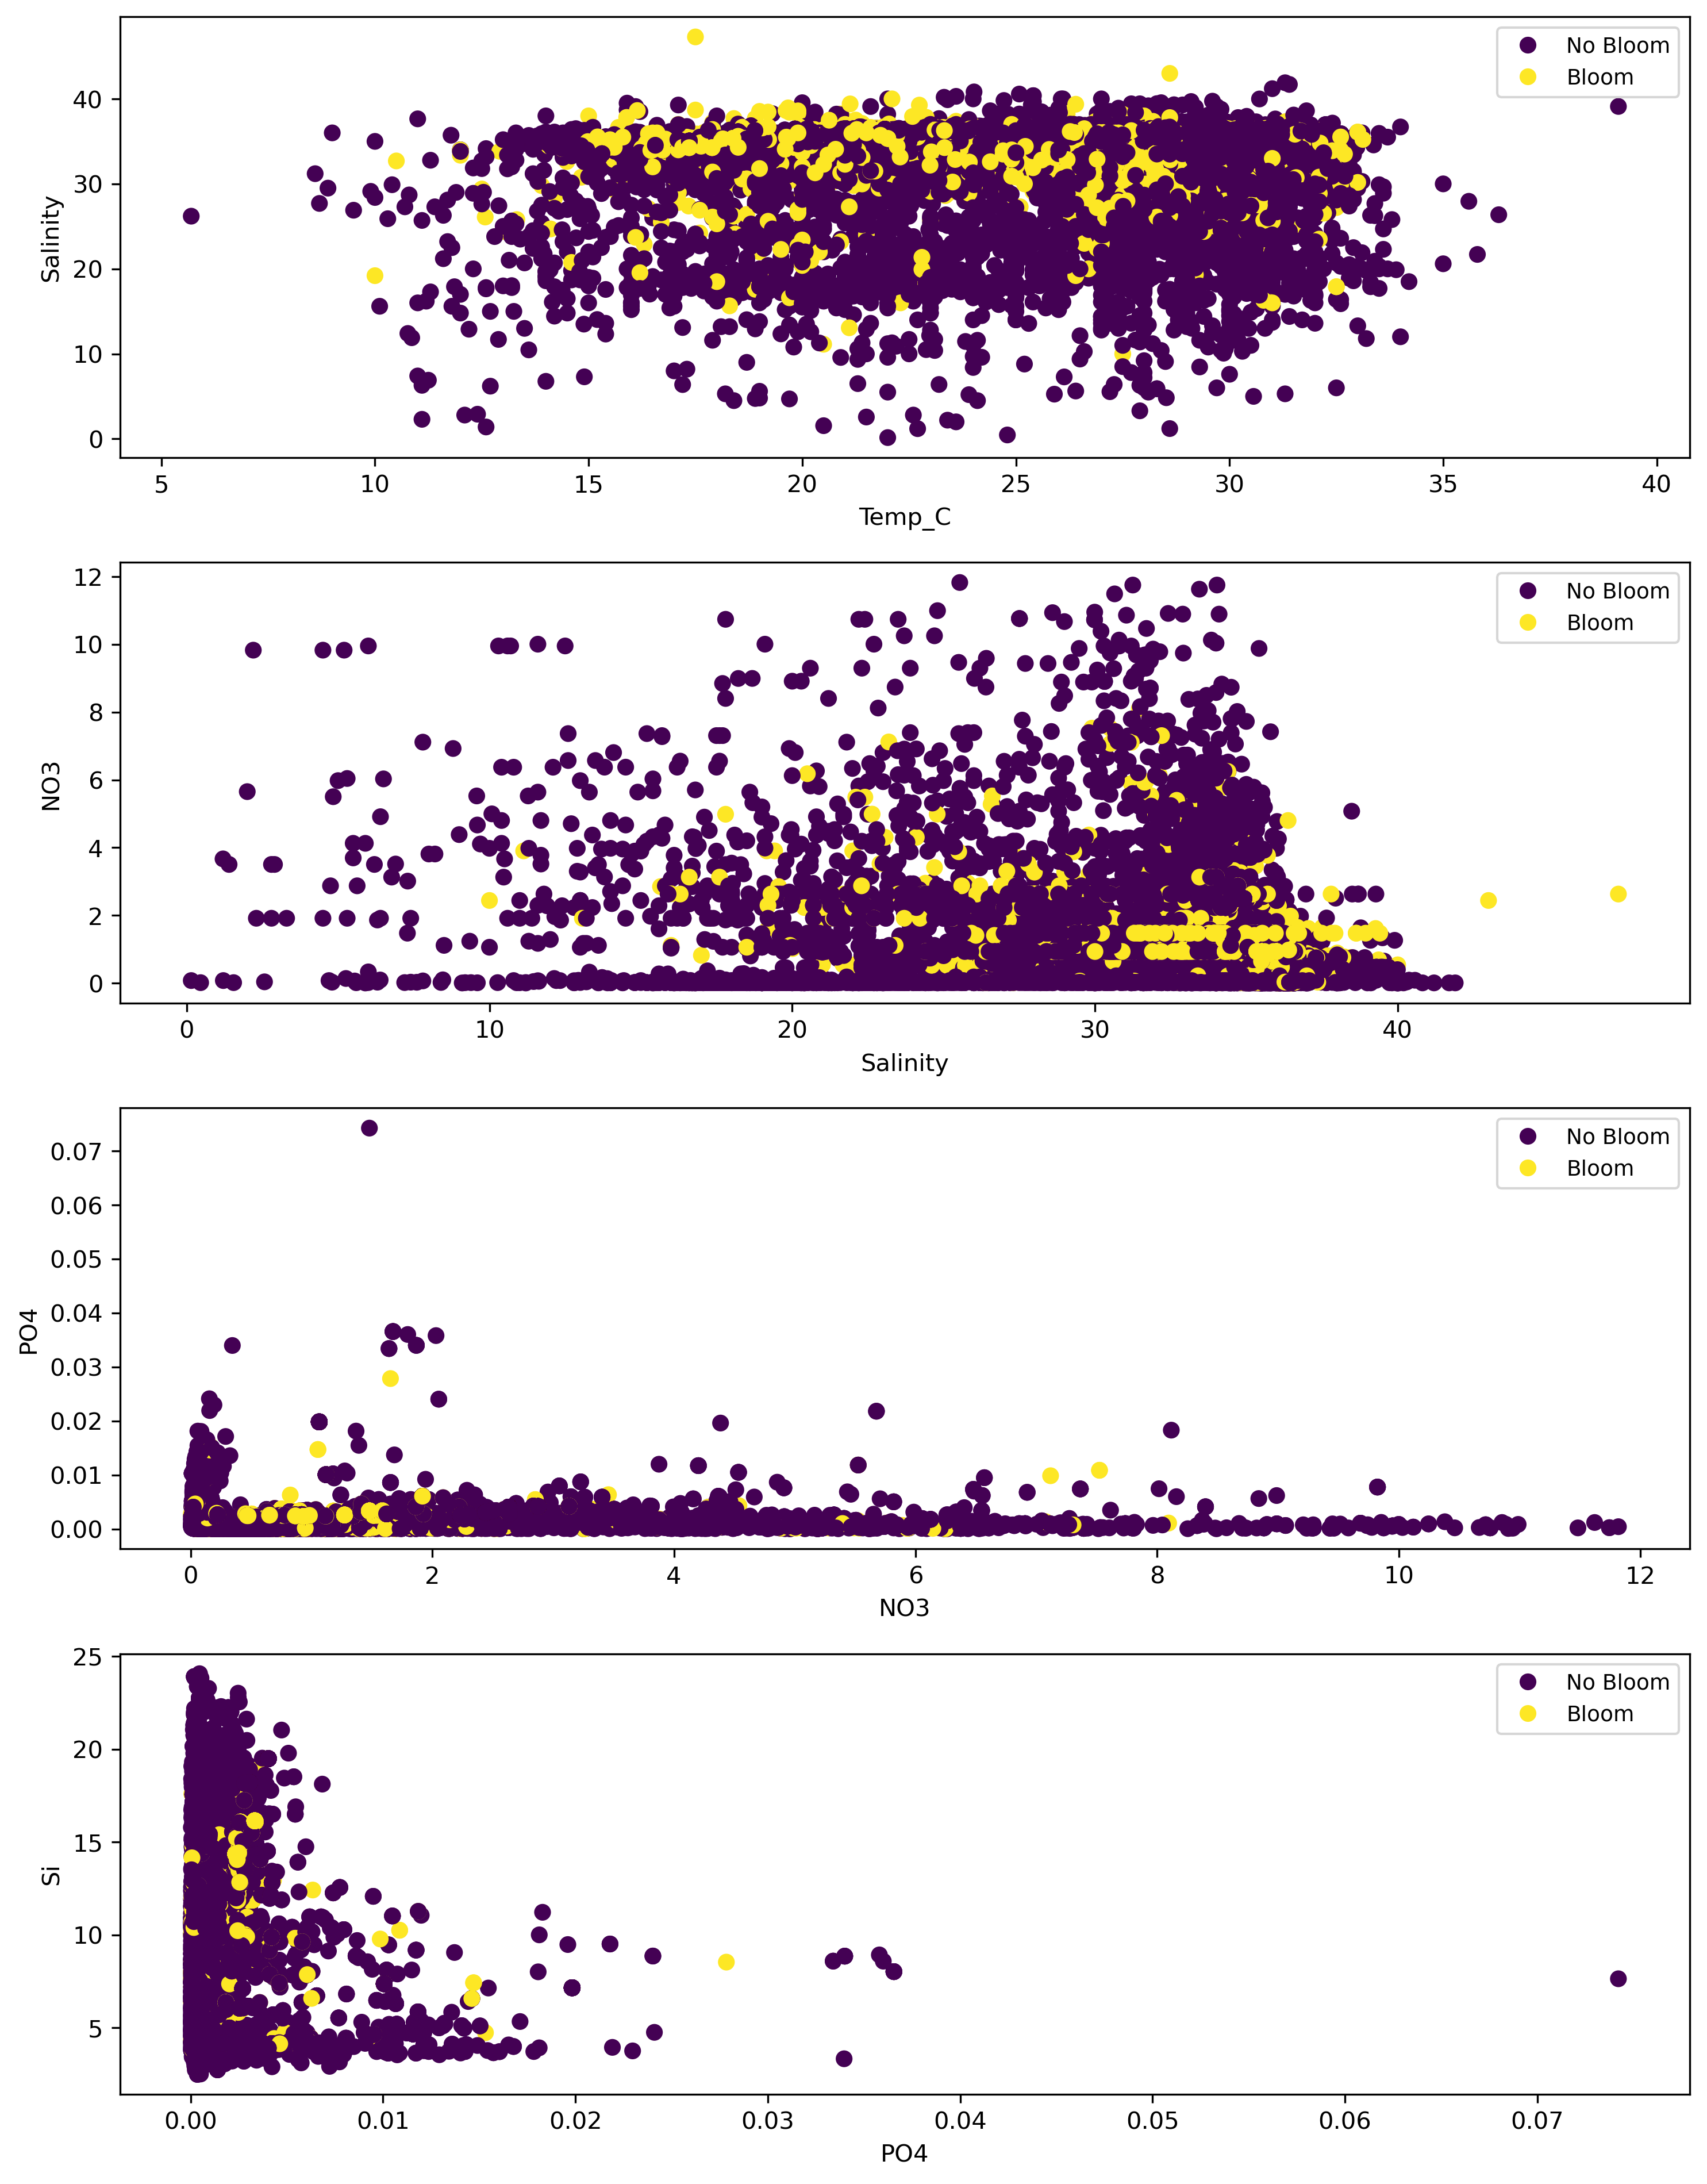

In [4]:
# Double check data first 
nrows, ncols = 8,1  #set 8 rows and 1 column
fig = plt.figure(figsize = (10,25), dpi = 300)

for i in range(1, 5): #i will iterate from 1 through 5
    ax = fig.add_subplot(nrows, ncols, i) #add subplot one at a time (#rows and columns, i is the position)
    PltScat=ax.scatter(x.iloc[:,i-1], x.iloc[:,i],c=y) #based on number of the column iloc is index location i-1 (starting point @ 0), i
    Label=label
    ax.legend(PltScat.legend_elements()[0],Label,prop = {'size' : 9})
    ax.set_xlabel(x.columns[i-1])
    ax.set_ylabel(x.columns[i])
plt.tight_layout()
plt.show()

In [5]:
## MODEL CONSTRUCTION

# Split data in train and test data (80:20)
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=4)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# FOR LOOP FOR BEST LAYER NEURON COMBO
#inputing scores here
scores = {}
scores_list = []

#build a nested loop to loop through both various numbers of layers and nodes
l_range = range(1, 4, 1)
neurons = [100,200,300,400,500]

for l in l_range:  
    for i in neurons:
            print(f"Combination: {l} layers with {i} neurons.") 
            mlp = MLPClassifier(hidden_layer_sizes=(i,)*l, random_state=1, max_iter=5000)
            mlp.fit(X_train, y_train)
            y_pred = mlp.predict(X_test)
            scores_list.append(metrics.accuracy_score(y_test,y_pred))
    #confusion matrix to determine the accuracy ( total # of correct predictions / by the total # of all predictions)
            print(confusion_matrix(y_test,y_pred))
            print(classification_report(y_test,y_pred))
            
print(scores_list)


Combination: 1 layers with 100 neurons.
[[1521   87]
 [ 310   95]]
              precision    recall  f1-score   support

           0       0.83      0.95      0.88      1608
           1       0.52      0.23      0.32       405

    accuracy                           0.80      2013
   macro avg       0.68      0.59      0.60      2013
weighted avg       0.77      0.80      0.77      2013

Combination: 1 layers with 200 neurons.
[[1551   57]
 [ 310   95]]
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1608
           1       0.62      0.23      0.34       405

    accuracy                           0.82      2013
   macro avg       0.73      0.60      0.62      2013
weighted avg       0.79      0.82      0.78      2013

Combination: 1 layers with 300 neurons.
[[1521   87]
 [ 293  112]]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1608
           1       0.56      0.28   

[[1510   98]
 [ 192  213]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1608
           1       0.68      0.53      0.59       405

    accuracy                           0.86      2013
   macro avg       0.79      0.73      0.75      2013
weighted avg       0.85      0.86      0.85      2013

0.8559364133134625


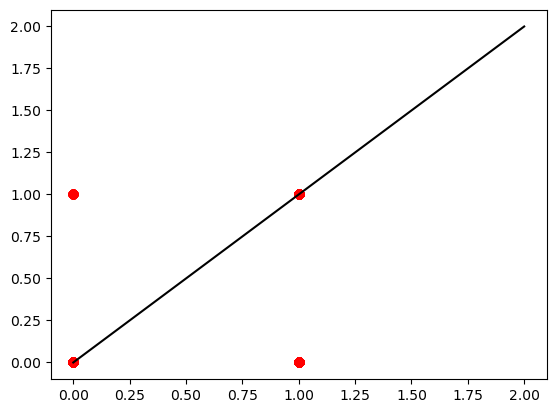

In [6]:
#From above, 3 layers with 300 neurons at 5000 iterations is the most accurate
#Proceed to create the model
#Neural network using MLPClassifier 

#Going through all of the hidden layers calculated above
# classifier with 3 layers
# max_iter= # of epochs
#1 epoch = combination of one cycle of feed-forward and back propagation phase.
mlp1 = MLPClassifier(hidden_layer_sizes=(300,300,300), random_state=1, max_iter=5000) 

# now fit the classifer to the training data
mlp1.fit(X_train, y_train)
# Predictions with classifier
predictions = mlp1.predict(X_test)

plt.plot(y_test, predictions, 'ro')
plt.plot([0, 2], [0, 2],'k')


#confusion matrix to determine the accuracy ( total # of correct predictions / by the total # of all predictions)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(metrics.accuracy_score(y_test,predictions))
#(precision, recall, f1scores must be > 0.90 to be considered acceptable)

#Confusion matrix tells us the model's prediction performance (false positives and false negatives)
#Precision tells us what proportion of true positives are actuall correct (TP/(TP+FP)
#Recall is what proportion of actual positives are identified correctly (TP/(TP+FN))
#F1 score is the model performance measurment (2*[(precision*recall)/(precision+recall)]) OR = (TP)/[(TP)+(1/2)(FP+FN)]
#Any value above 0.90 is pretty accurate

In [7]:
# here we apply the new model built above to 'new' data

classes = {0:'No Bloom',1:'Bloom'}

# Make a prediction for the 'new' data - WFS2019 data

bdf=CF.DownloadCSV('WFS_2019_HydrogeoData.csv','bdf')

bdfTotal=CF.DownloadCSV('WFS_2019_TotalData.csv','bdfTotal')

x_new = bdf
x_new_scaled = scaler.transform(x_new)
x_new

,Temp_C,Salinity,NO3,PO4,Si
0,23.50745,34.0873,0.00,3.37,0.10
1,23.71135,34.9625,0.18,4.03,0.00
2,23.28010,35.5562,0.00,0.89,0.00
3,23.23490,35.9227,0.00,1.18,0.00
4,23.70525,36.3937,0.00,1.32,0.00
5,25.17660,36.4772,0.00,0.92,0.00
6,23.07830,36.2678,0.00,1.13,0.00
7,23.77495,36.4099,0.00,0.81,0.00
8,23.95225,36.3924,0.00,1.08,0.00
9,23.32540,36.3023,0.00,1.41,0.00


In [8]:
y_predict = mlp1.predict(x_new_scaled)
print(classes[y_predict[0]])
print(classes[y_predict[1]])
print(classes[y_predict[2]])
print(classes[y_predict[3]])
print(classes[y_predict[4]])
print(classes[y_predict[5]])
print(classes[y_predict[6]])
print(classes[y_predict[7]])
print(classes[y_predict[8]])
print(classes[y_predict[9]])
print(classes[y_predict[10]])
print(classes[y_predict[11]])
print(classes[y_predict[12]])
print(classes[y_predict[13]])
#probability that each unknown wine fits into target classes
predictprob=mlp1.predict_proba(x_new_scaled)
Report= pd.DataFrame(predictprob)
Report

#My model is predicting the probability of the unknowns as mostly no Blooms (with a 100% certainty). 
#

No Bloom
No Bloom
No Bloom
No Bloom
No Bloom
No Bloom
No Bloom
No Bloom
No Bloom
No Bloom
No Bloom
No Bloom
No Bloom
No Bloom


,0,1
0,1.0,0.000000e+00
1,1.0,0.000000e+00
2,1.0,2.748071e-192
3,1.0,6.685027e-258
4,1.0,3.722210e-290
5,1.0,1.878796e-201
6,1.0,4.134108e-246
7,1.0,2.229301e-174
8,1.0,5.310508e-236
9,1.0,0.000000e+00


C:\Users\krist\anaconda3\envs\ConfesorCapstoneEnv\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\krist\anaconda3\envs\ConfesorCapstoneEnv\Lib\site-packages\cartopy\mpl\gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
C:\Users\krist\anaconda3\envs\ConfesorCapstoneEnv\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


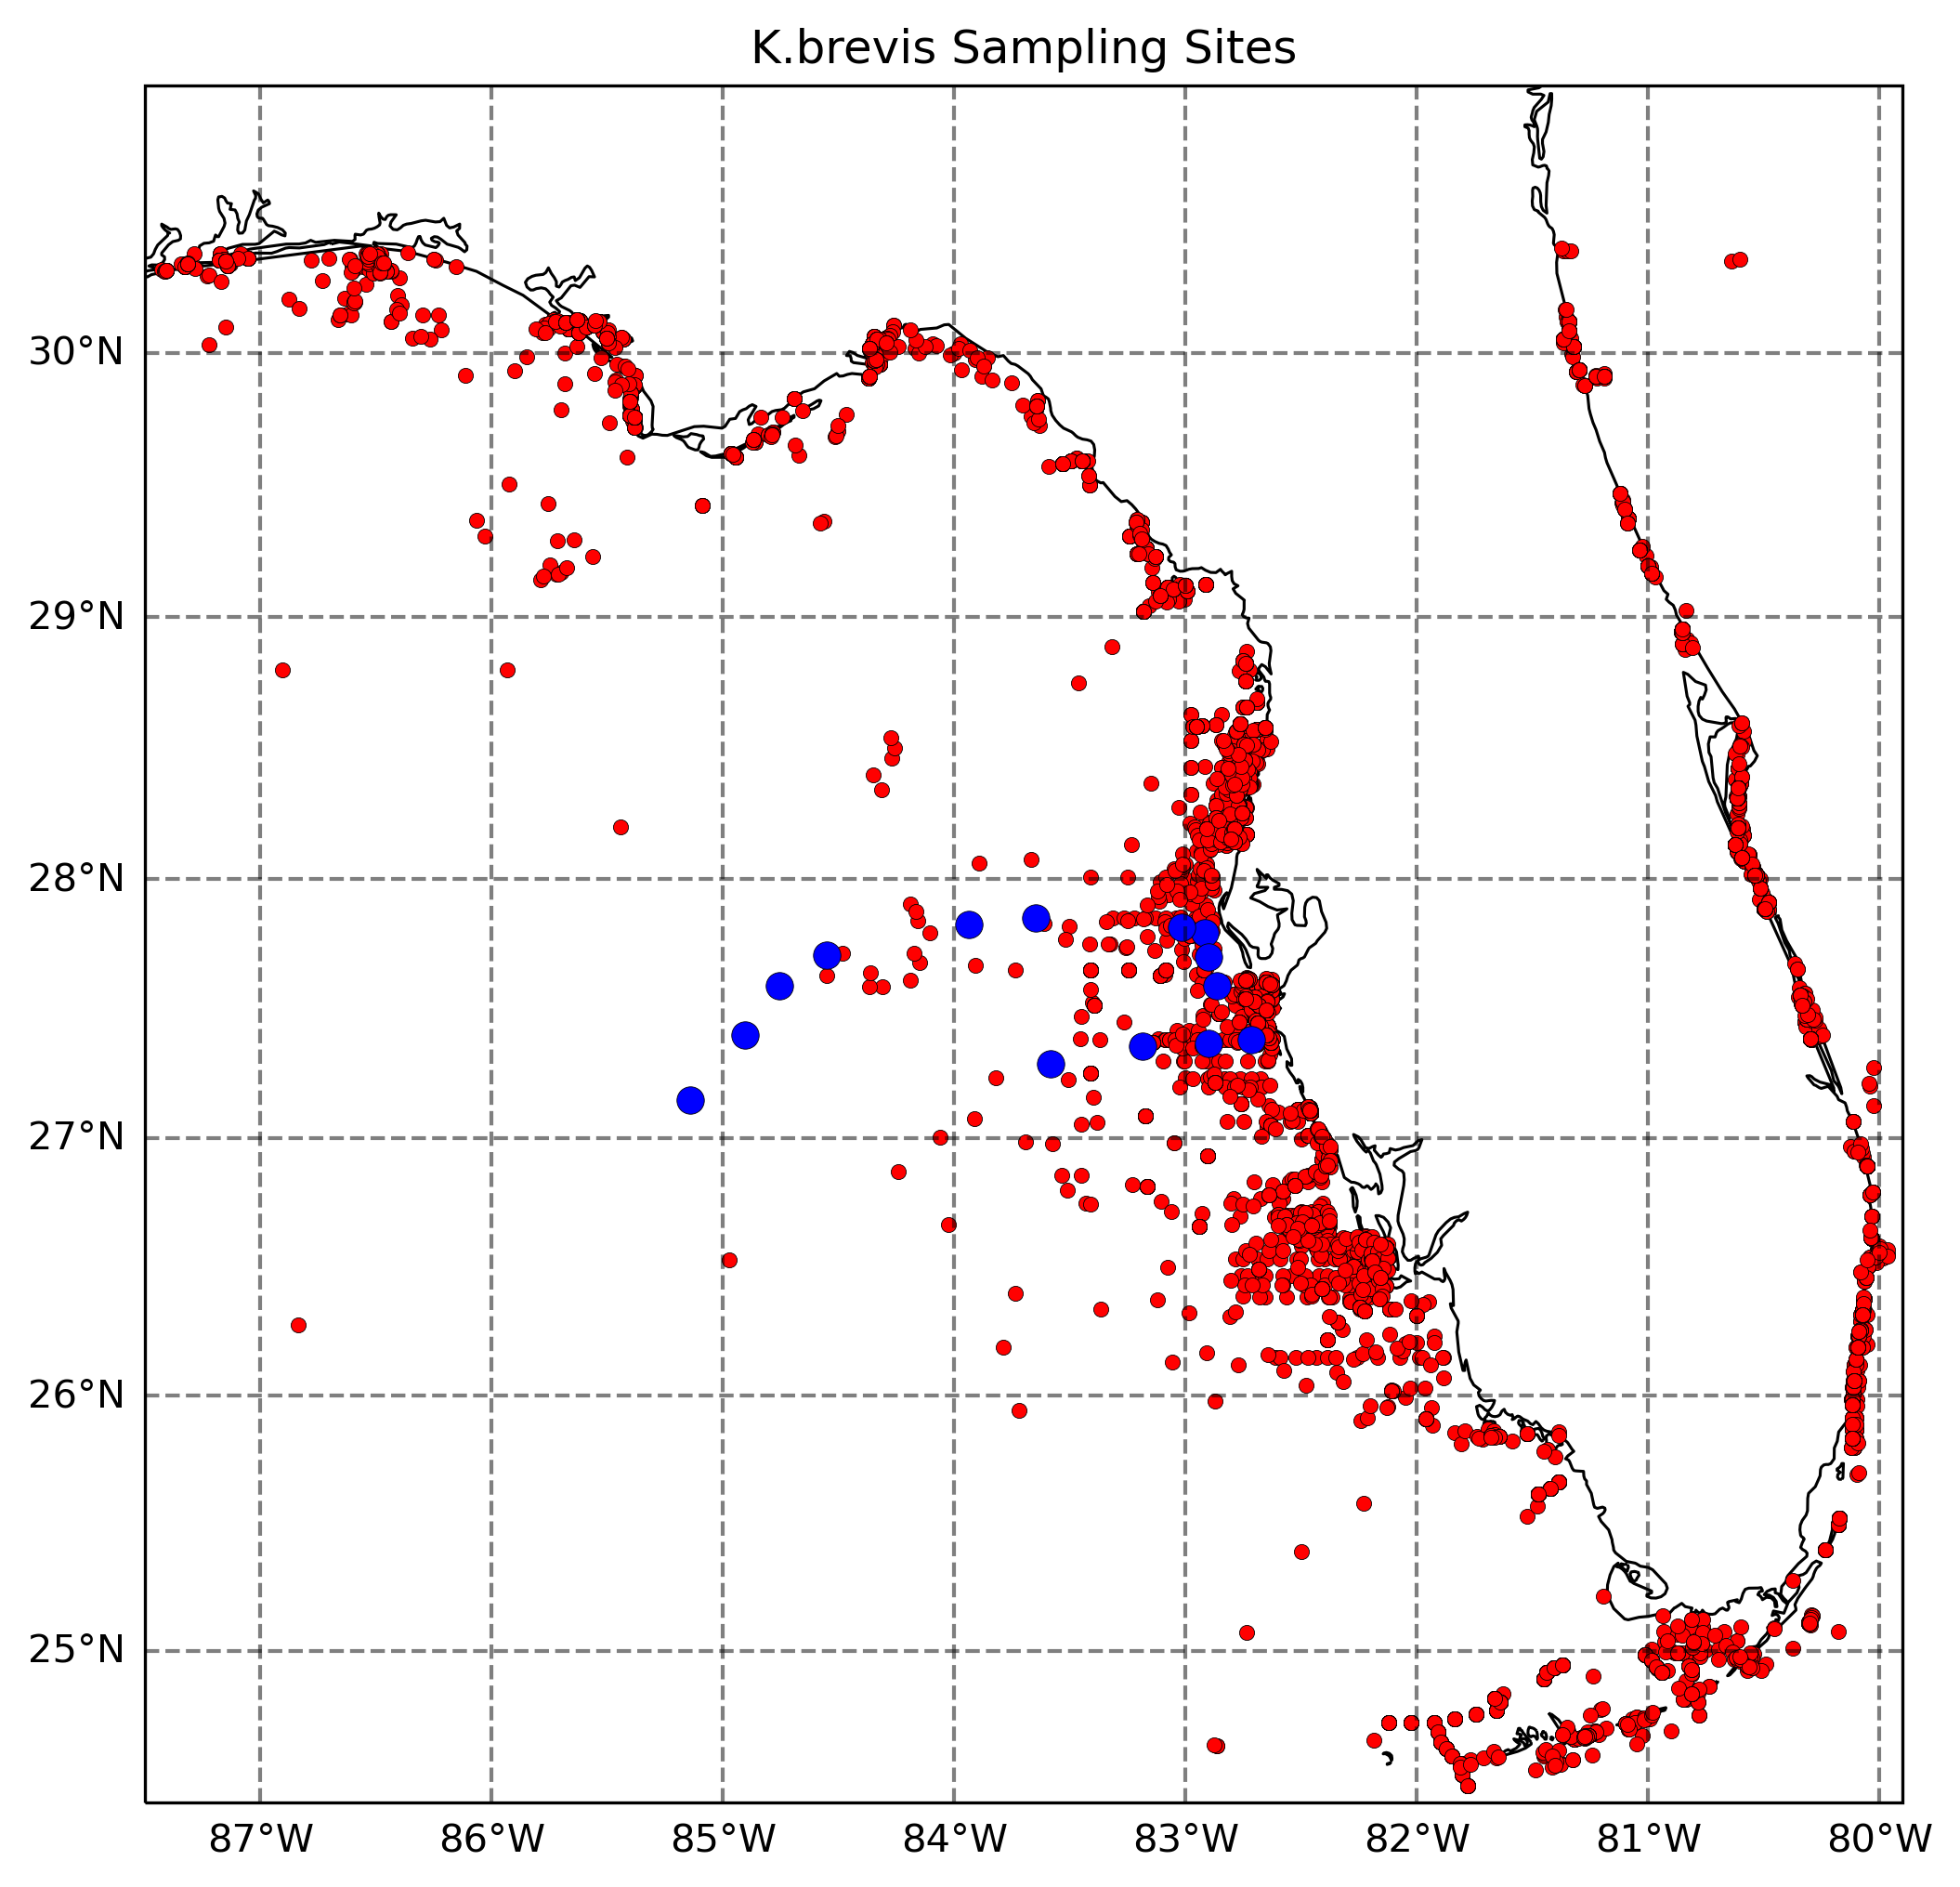

In [9]:
# Plotting Model vs New Data

fig = plt.figure(figsize = (10,8), dpi = 300)
ax = fig.add_subplot(1,1,1, projection = ccrs.Mercator(central_longitude = 0.0, min_latitude = 24, max_latitude = 31))

# ax.set_extent(east, west, south, north)
ax.set_extent([-87.5, -79.9, 24.4, 49])
ax.coastlines(linewidth=0.75, color='black',zorder=0)
ax.set_title('K.brevis Sampling Sites')#, color = 'red', weight = 'bold')
nn = ax.scatter(Kb_final.Longitude, Kb_final.Latitude,s=15,c='red',zorder=1,edgecolors='black',linewidths=0.2,
           transform=ccrs.PlateCarree())
NN=ax.scatter(bdfTotal.Lon,bdfTotal.Lat,s=50,c='blue',zorder=2,edgecolors='black',linewidths=0.2,
           transform=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k',linestyle='--',alpha=0.5)
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.show()
#fig.savefig('KbrevisSampling.png',format='png',dpi=600,transparent=False)

### Cross-validation with KFold

In [15]:
# Use KFold
#define cross-validation method to use
kf = KFold(n_splits=5, shuffle=True, random_state=1)

#use k-fold CV to evaluate model
scores = cross_val_score(mlp1, x, y, scoring='neg_root_mean_squared_error',cv=kf, n_jobs=-1)

In [16]:
#The scores (RMSE) are close to 0, meaning the model is accurate
#When making new models with different combinations of parameters, try to get scores that are closer to 0
print(scores)

[-0.43505143 -0.42872516 -0.44632406 -0.40976651 -0.42240907]
